In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from google.cloud import bigquery
from tqdm import tqdm


from forecast import *

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

### Data Retrieval

In [3]:
REFRESH=False

In [4]:
if REFRESH:
    
    sql = '''
        DECLARE latest_date DATE;
        SET latest_date = (
            SELECT MAX(offer_start_date) 
            FROM `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales_solus`  fcs
            WHERE campaign_code IN (
                SELECT DISTINCT campaign_code || '-' || campaign_type
                FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
            )
        );
        
        CREATE OR REPLACE TABLE `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_CAT_FORECASTING_DEV` AS
        WITH dates_campaign AS (
            SELECT * 
            FROM (
                SELECT DISTINCT fw_start_date + 1 AS fw_start_date
                FROM `wx-bq-poc.loyalty.dim_date`
                WHERE fw_start_date >= '2021-04-20'
                    AND fw_start_date <= latest_date
            )
                CROSS JOIN (
                    SELECT DISTINCT 
                        Campaign_Seg_Grp_Id
                    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
                    WHERE Campaign_Seg_Grp_Id != 'None'
                )
            GROUP BY 1,2
        ),
        
        audience AS (
            SELECT 
                campaign_start_date,
                Campaign_Seg_Grp_Id,
                COUNT(DISTINCT crn) AS audience
            FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
            GROUP BY 1,2
        ),

        promo AS (
            SELECT 
                ma.Campaign_Seg_Grp_Id,
                fcs.campaign_start_date,
                fcs.offer_start_date,
                0 AS post_week_flag,
                COUNT(DISTINCT fcs.redeem_flag) AS redeemers,
                SUM(fcs.attributed_inc_sales) AS inc_sales,
                SUM(fcs.reward_val) AS cost
            FROM
                `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales_solus` fcs
                JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
                    ON fcs.crn = ma.crn
                    AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
                    AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
            WHERE offer_start_date >= '2021-04-19'
                AND offer_start_date <= latest_date
                AND Campaign_Seg_Grp_Id != 'None'
            GROUP BY 1,2,3,4
        ), 

        post AS (
            SELECT  
                ma.Campaign_Seg_Grp_Id,
                fcs.campaign_start_date,
                fcs.fw_start_date + 1,
                1 AS post_week_flag,
                0 AS redeemers,
                SUM(fcs.inc_sales) AS inc_sales,
                0 AS cost
            FROM 
                `wx-bq-poc.loyalty_bi_analytics.cp_att_crn_halo_post_all` fcs
                JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
                    ON fcs.crn = ma.crn
                    AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
                    AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
            WHERE fw_start_date >= '2021-04-19'
                AND fw_start_date <= latest_date
                AND Campaign_Seg_Grp_Id != 'None'
            GROUP BY 1,2,3,4
        ),

         _promo_post AS (
            SELECT * FROM promo 
            UNION ALL
            SELECT * FROM post
        ),
        
        promo_post AS (
            SELECT
                pp.*, a.audience
            FROM _promo_post pp
                JOIN audience a 
                    ON pp.Campaign_Seg_Grp_Id = a.Campaign_Seg_Grp_Id
                    AND pp.campaign_start_date = DATE(a.campaign_start_date)
        )

        SELECT
            dc.fw_start_date - 1 AS ds,
            dc.Campaign_Seg_Grp_Id AS offer_type,
            SUM(audience) AS promo_post_audience,
            SUM(audience) - SUM(CASE WHEN post_week_flag = 1 THEN audience ELSE 0 END) AS promo_audience,
            SUM(inc_sales) AS inc_sales,
            SUM(redeemers) AS redeemers,
            SUM(cost) AS cost
        FROM 
            dates_campaign dc
            LEFT JOIN promo_post pp
                ON dc.fw_start_date = pp.offer_start_date
                AND dc.Campaign_Seg_Grp_Id = pp.Campaign_Seg_Grp_Id
        GROUP BY 1, 2
        ORDER BY 1, 2;
    '''

    response = bq.query(sql).result()

In [5]:
sql = '''
    SELECT *
    FROM `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_CAT_FORECASTING_DEV`
'''

data = bq.query(sql).result().to_dataframe()

data['inc_sales'] = data['inc_sales'].astype(float)
data['redeemers'] = data['redeemers'].astype(float)
data['cost'] = data['cost'].astype(float)
data['promo_post_audience'] = data['promo_post_audience'].astype(float)
data['promo_audience'] = data['promo_audience'].astype(float)

data['rpc'] = data['inc_sales'] / data['promo_post_audience']
data['rdm'] = data['redeemers'] / data['promo_audience']
data['cpc'] = data['cost'] / data['promo_audience']

# data = data[~data['offer_type'].isin(['None'])]
offer_list = list(data['offer_type'].unique())


### Parameters

In [6]:
WINDOW = 6

### Forecasts

In [7]:
def evaluate(forecastClass, plot=False):

    smape_df = pd.DataFrame({
        'offer_type': offer_list,
        'rpc': 0,
        'rdm': 0,
        'cpc': 0,
        'promo_post_audience': 0,
        'promo_audience': 0
    })
    smape_df.set_index('offer_type', inplace=True)
            
    for metric in ['rpc', 'rdm', 'cpc']:
        
        print(f'Evaluating {metric}...')
                
        for offer in tqdm(offer_weight.keys()):

            myForecast = forecastClass(
                data=data, 
                offer_type=offer,
                metric=metric,
                window=WINDOW
            )
        
            myForecast.train()
            
            if plot:
                myForecast.plot_forecast()
    
            curr_smape = myForecast.evaluate()
            smape_df.loc[offer, metric] = curr_smape
        
    return smape_df

In [8]:
def eval_smape(y, yhat):
    return np.mean(np.abs(yhat - y) / (np.abs(yhat) + np.abs(y))) * 100

##### Ensemble

In [9]:
import forecast

def ensemble(data):
    
    forecastClasses = ['ForecastNaive', 'ForecastES', 'ForecastARIMA', 'ForecastProphet']
    forecast_df = pd.DataFrame({
        'offer_type': offer_list,
        'rpc': None,
        'rdm': None,
        'cpc': None,
        'promo_post_audience': None,
        'promo_audience': None
    })
    forecast_df.set_index('offer_type', inplace=True)
    
    smape_df = pd.DataFrame({
        'offer_type': offer_list,
        'rpc': 0,
        'rdm': 0,
        'cpc': 0,
        'promo_post_audience': 0,
        'promo_audience': 0
    })
    smape_df.set_index('offer_type', inplace=True)
            
    for metric in ['rpc', 'rdm', 'cpc', 'promo_post_audience', 'promo_audience']:
        
        print(f'Evaluating {metric}...')
                
        for offer in tqdm(offer_list):
                        
            smape_list = []
            for forecastClass in forecastClasses:
                
                forecastClass = getattr(forecast, forecastClass)
                myForecast = forecastClass(
                    data=data, 
                    offer_type=offer,
                    metric=metric,
                    window=WINDOW
                )

                myForecast.train()
                smape_list.append(myForecast.evaluate())

            forecastClassIdx = np.argmin(smape_list)
            selectedForecast = forecastClasses[forecastClassIdx]
            forecast_df.loc[offer, metric] = selectedForecast
            
            curr_smape = np.min(smape_list)
            smape_df.loc[offer, metric] = curr_smape
                    
    return forecast_df, smape_df


def plot_ensemble(forecast_df):
    
    for metric in ['rpc', 'rdm', 'cpc', 'promo_post_audience', 'promo_audience']:
        
        for offer in offer_list:
            
            forecastClass = getattr(forecast, forecast_df.loc[offer, metric])
            myForecast = forecastClass(
                    data=data, 
                    offer_type=offer,
                    metric=metric,
                    window=WINDOW
                )
            myForecast.train()
            myForecast.plot_forecast()

In [10]:
%%time
from forecast import *
train_data = data[data['ds'] < data['ds'].unique()[-WINDOW]]
forecast_df, smape_df = ensemble(train_data)

Evaluating rpc...


 93%|█████████▎| 14/15 [01:48<00:07,  7.93s/it]/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
100%|██████████| 15/15 [01:58<00:00,  7.89s/it]


Evaluating rdm...


 93%|█████████▎| 14/15 [02:02<00:08,  8.41s/it]/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
100%|██████████| 15/15 [02:11<00:00,  8.74s/it]


Evaluating cpc...


 93%|█████████▎| 14/15 [02:05<00:09,  9.31s/it]/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
100%|██████████| 15/15 [02:14<00:00,  8.98s/it]


Evaluating promo_post_audience...


 93%|█████████▎| 14/15 [01:35<00:07,  7.01s/it]/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1154: RuntimeWarning: divide by zero encountered in log
  logL = -self.nobs / 2 * (np.log(2 * np.pi * np.mean(res ** 2)) + 1)
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1154: RuntimeWarning: invalid value encountered in cdouble_scalars
  logL = -self.nobs / 2 * (np.log(2 * np.pi * np.mean(res ** 2)) + 1)
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tools

Evaluating promo_audience...


 93%|█████████▎| 14/15 [01:40<00:07,  7.14s/it]/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
100%|██████████| 15/15 [01:49<00:00,  7.31s/it]

CPU times: user 12min 41s, sys: 4min 18s, total: 17min
Wall time: 9min 55s


##### Naive

In [11]:
# n_smape_df, n_smape_dict = evaluate(ForecastNaive, plot=False)
# n_smape_df, n_smape_dict

##### Exponential Smoothing

In [12]:
# es_smape_df = evaluate(ForecastES, plot=False)
# es_smape_df

##### Auto-ARIMA

In [13]:
# aa_smape_df = evaluate(ForecastARIMA, plot=False)
# aa_smape_df

##### Facebook Prophet

In [14]:
# fp_smape_df = evaluate(ForecastProphet, plot=False)
# fp_smape_df

### Prediction by Offer Type

In [15]:
def single_plot(metric):
    for offer in offer_list:
        forecastClass = getattr(forecast, forecast_df.loc[offer, metric])
        myForecast = forecastClass(
            data=data, 
            offer_type=offer,
            metric=metric,
            window=WINDOW
        )
        myForecast.train()
        myForecast.plot_forecast()
    
def product_plot(metric):
    
    if metric == 'cost':
        scale, value = 'cpc', 'promo_audience'
    elif metric == 'redeemers':
        scale, value = 'rdm', 'promo_audience'
    elif metric == 'inc_sales':
        scale, value = 'rpc', 'promo_post_audience'
    
    for offer in offer_list:
        forecastClass = getattr(forecast, forecast_df.loc[offer, value])
        myForecast = forecastClass(
            data=data, 
            offer_type=offer,
            metric=value,
            window=WINDOW
        )
        myForecast.train()
        pred_value = myForecast.predict()
        df_value = myForecast.df

        forecastClass = getattr(forecast, forecast_df.loc[offer, scale])
        myForecast = forecastClass(
            data=data, 
            offer_type=offer,
            metric=scale,
            window=WINDOW
        )
        myForecast.train()
        pred_scale = myForecast.predict()
        df_scale = myForecast.df

        df = df_value.merge(df_scale, left_on='ds', right_on='ds')
        df['y'] = df['y_x'] * df['y_y']

        ds = df.ds
        y = df.y
        yhat = pred_scale * pred_value

        plt.figure(figsize=(20,5))
        plt.title(f"{offer} - {metric}")
        plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
        plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
        plt.plot(ds[-WINDOW:], yhat, label='pred')
        plt.legend()
        plt.grid()
        plt.show()

rpc


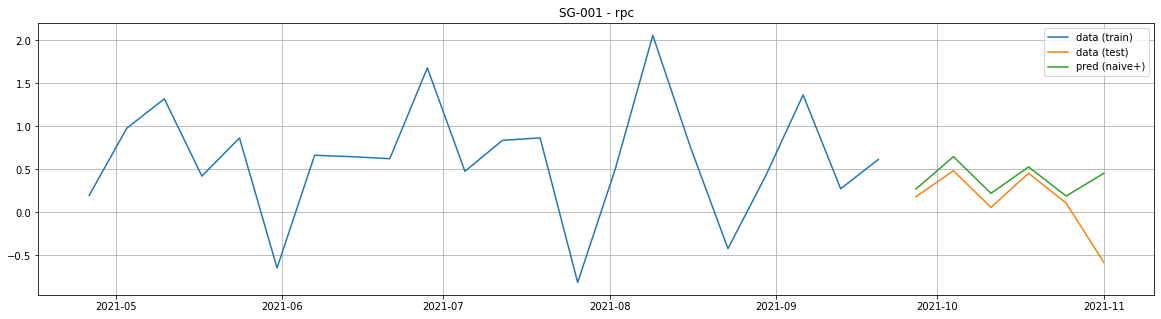

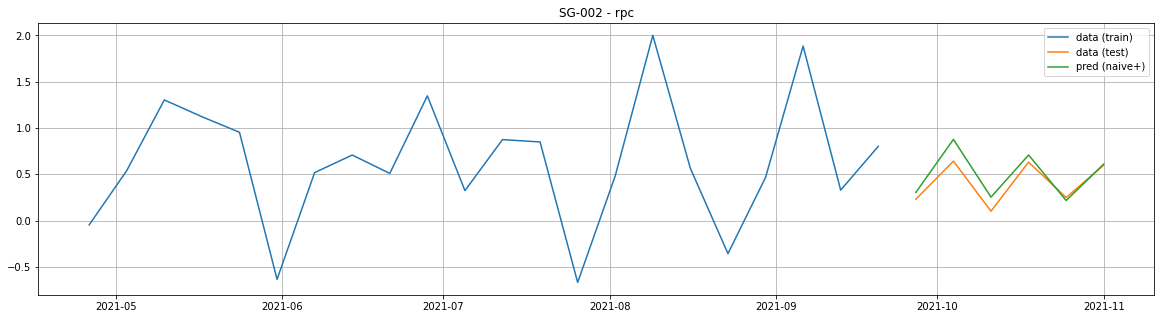

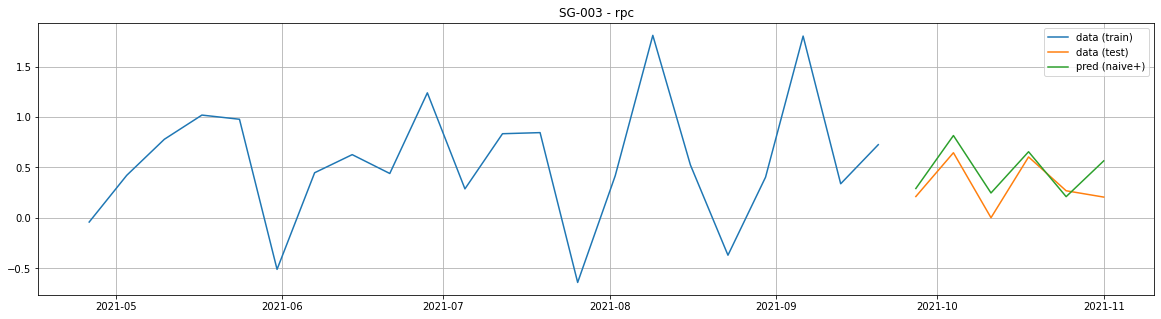

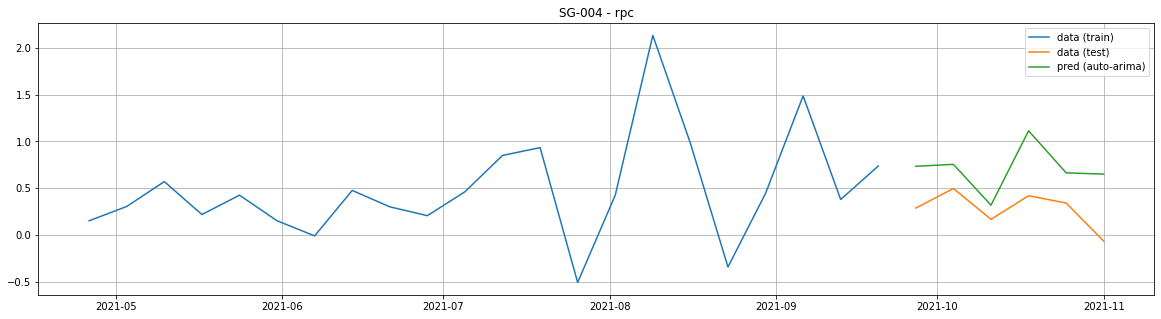

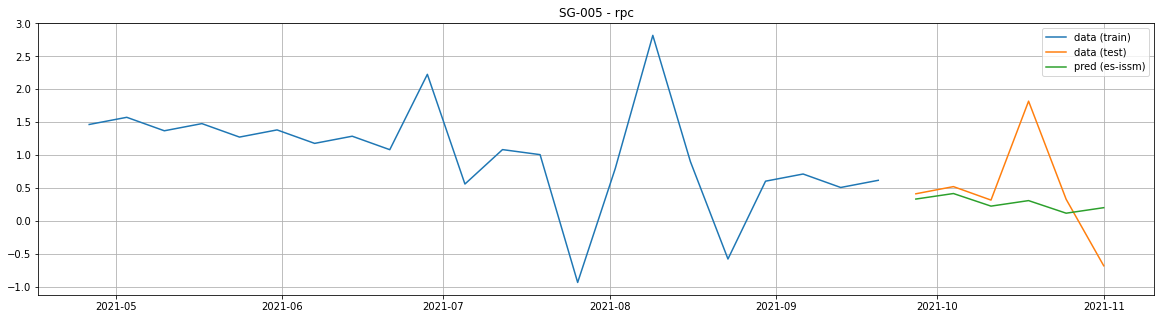

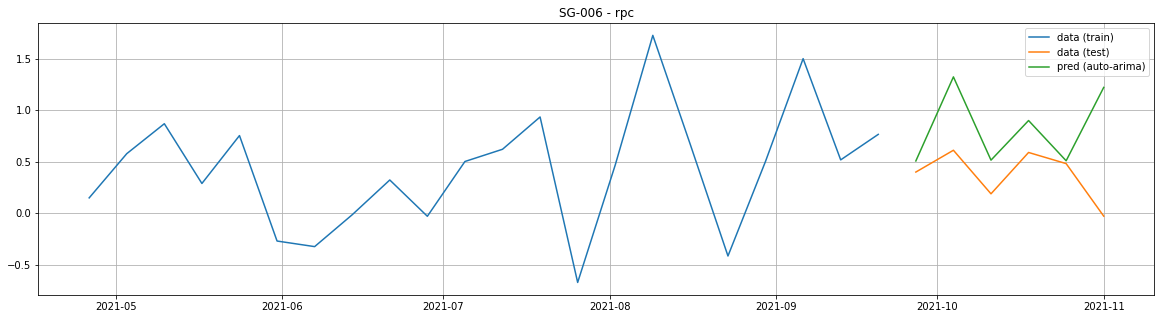

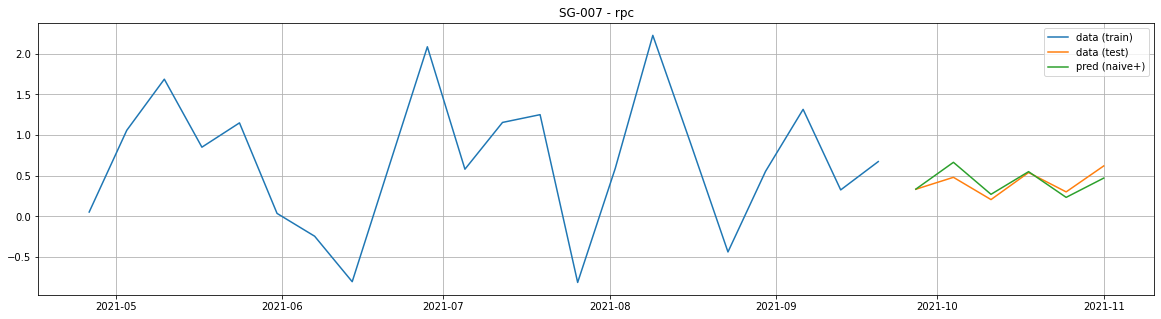

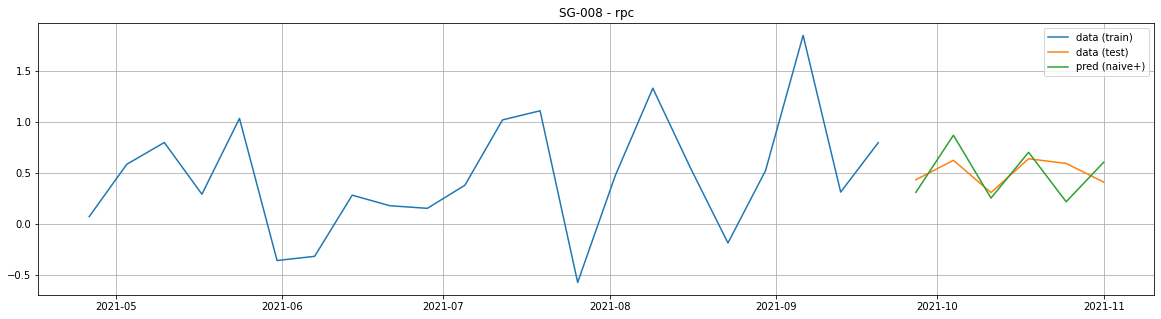

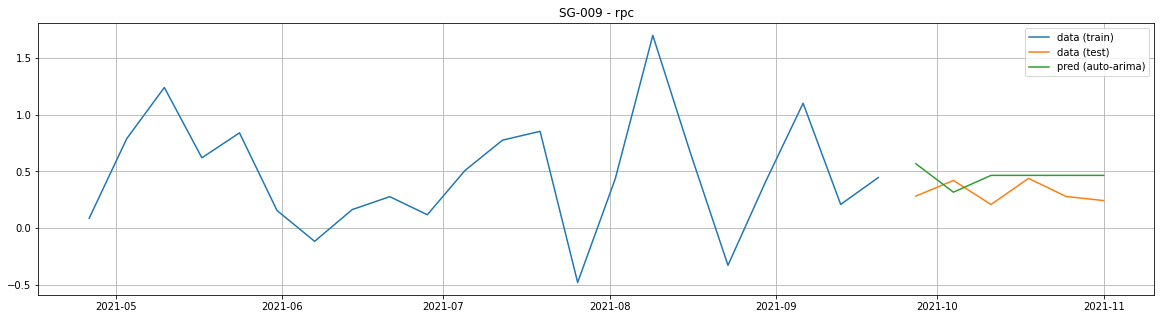

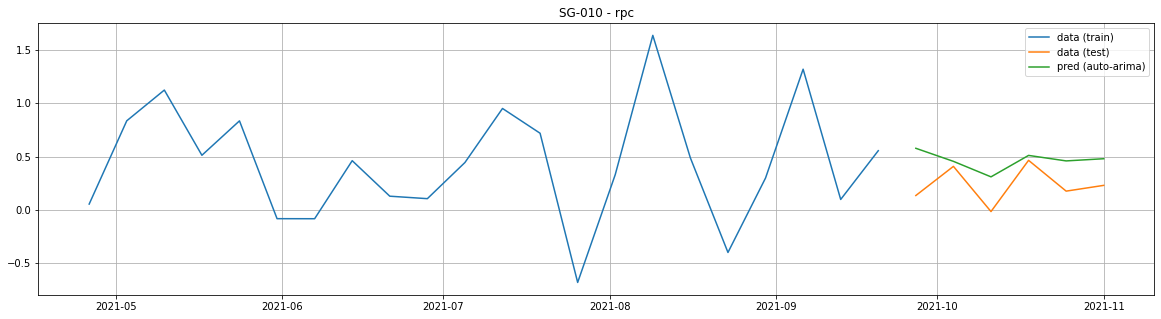

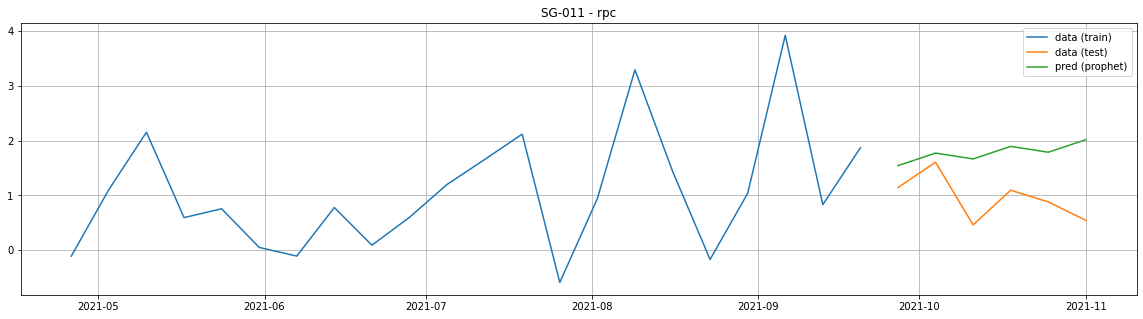

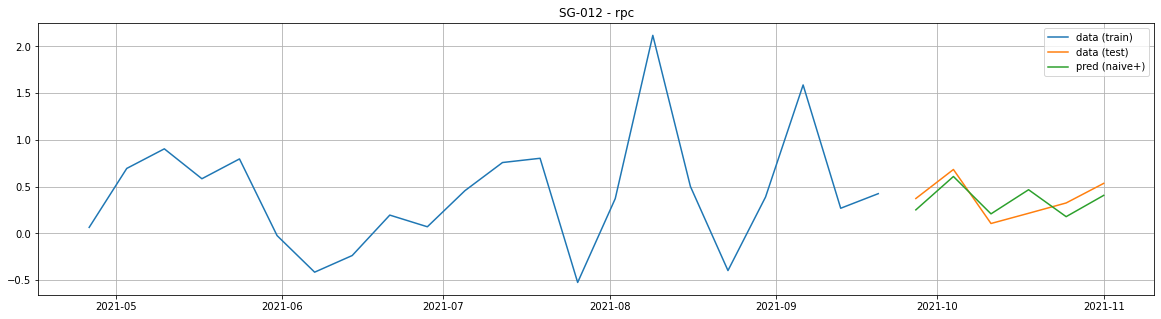

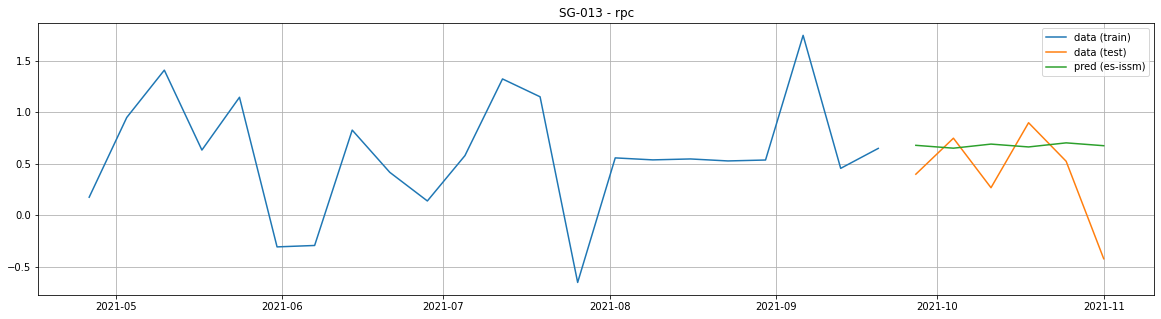

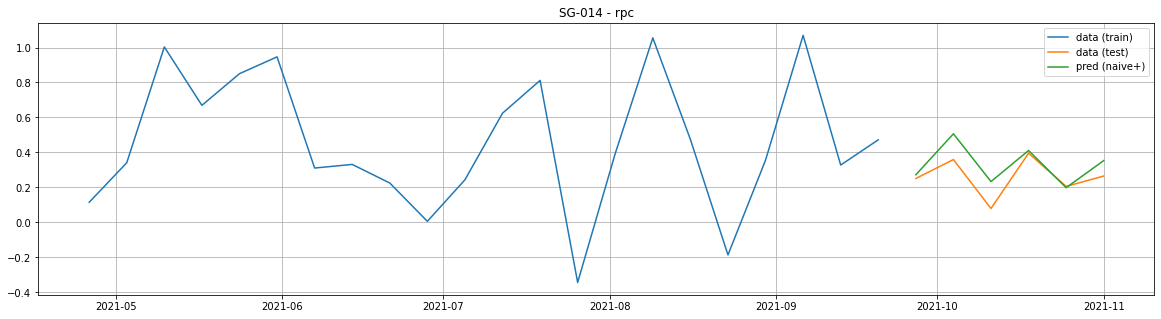

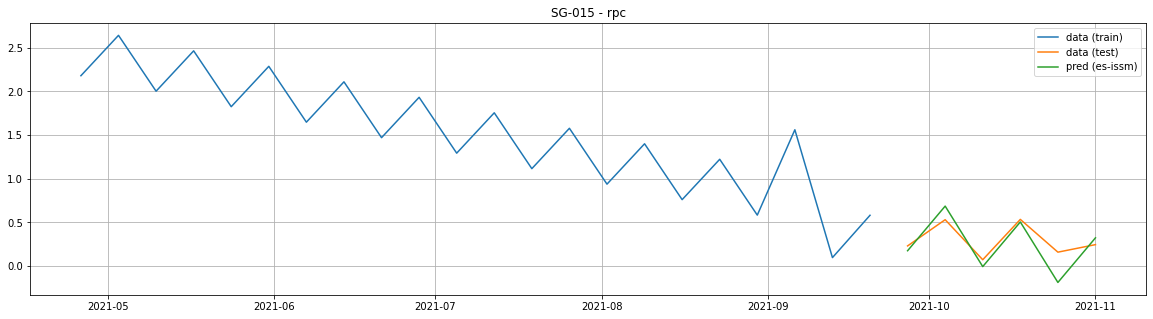

rdm


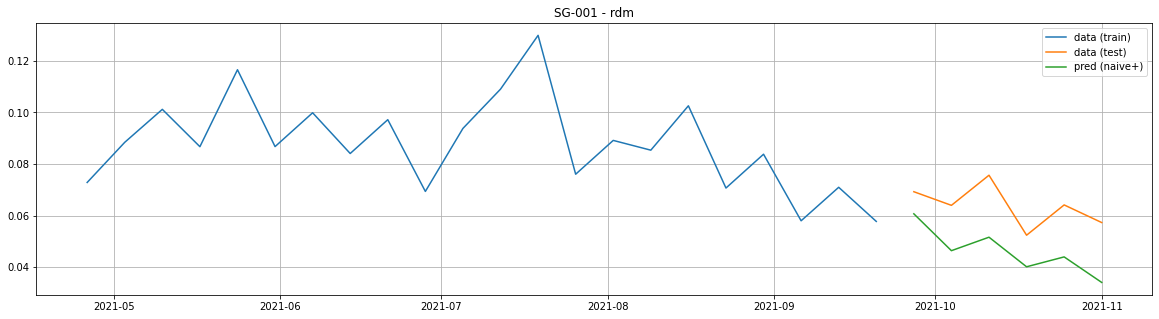

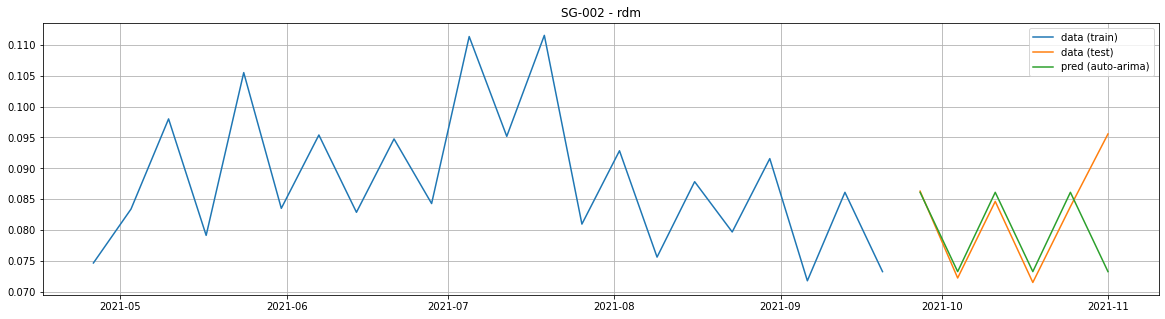

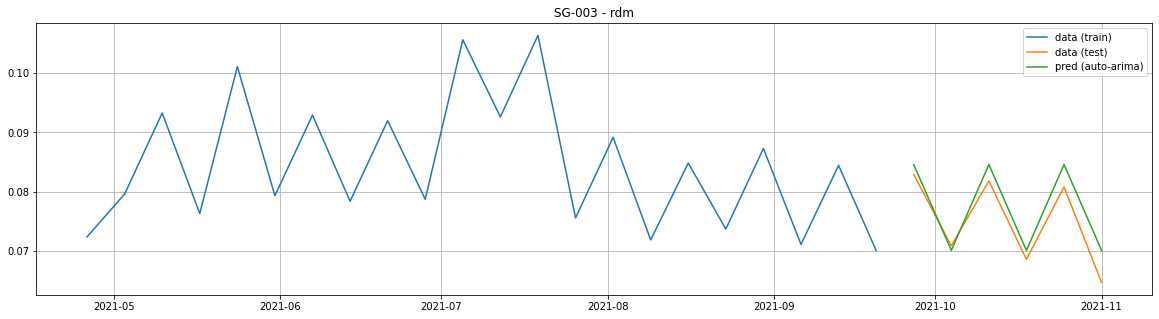

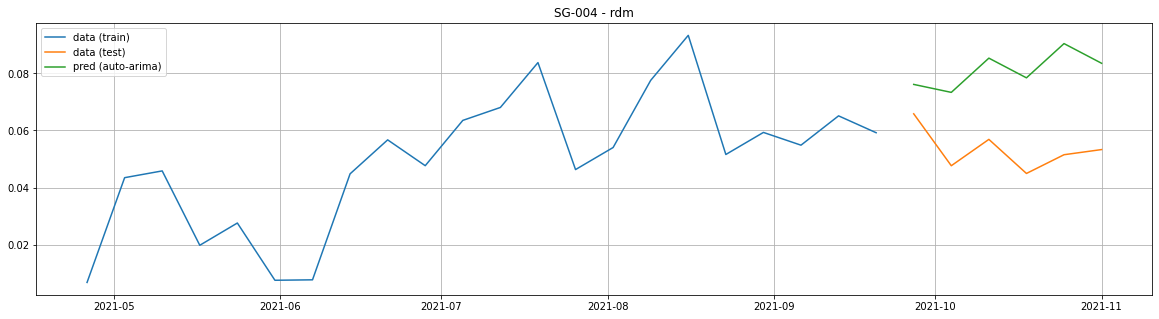

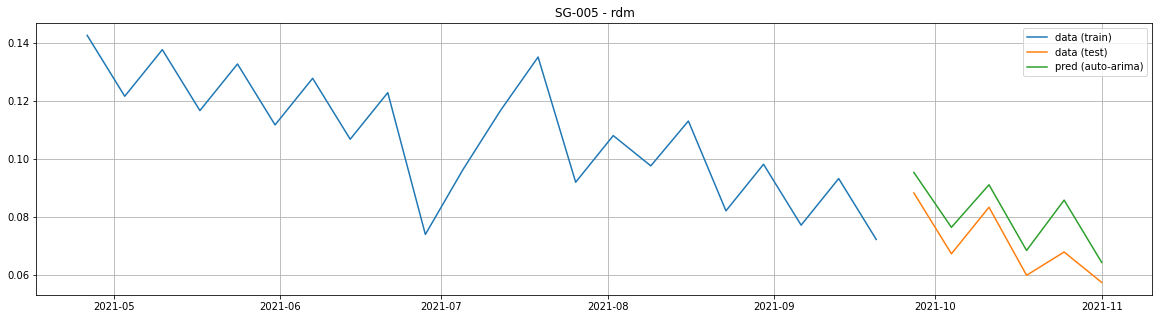

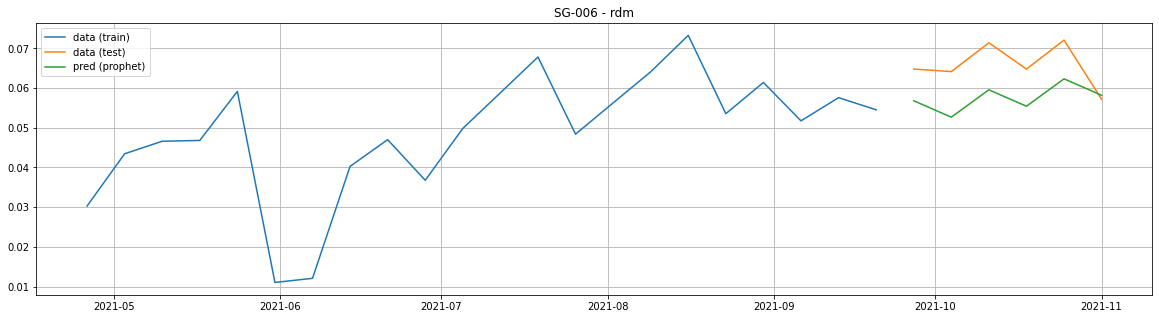

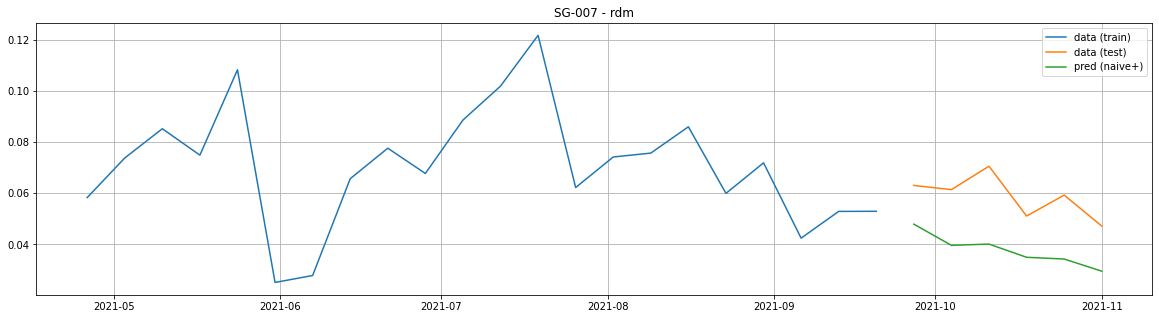

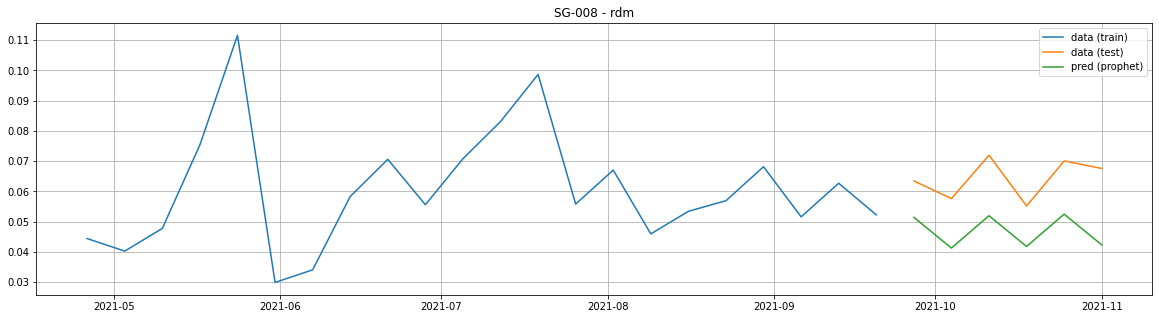

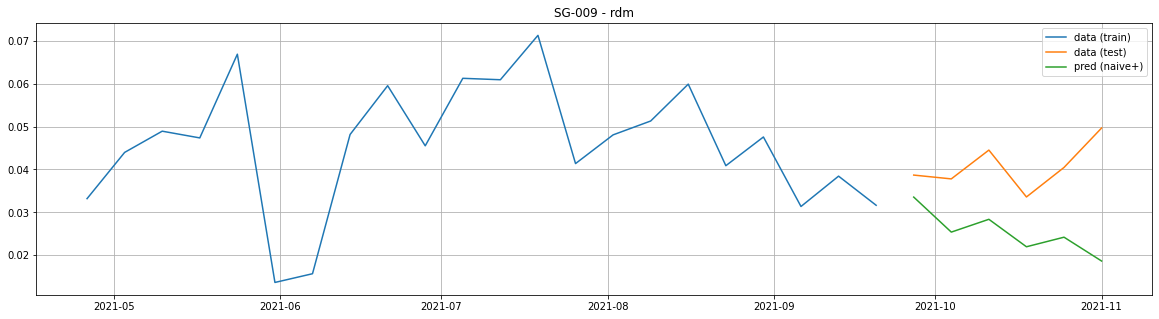

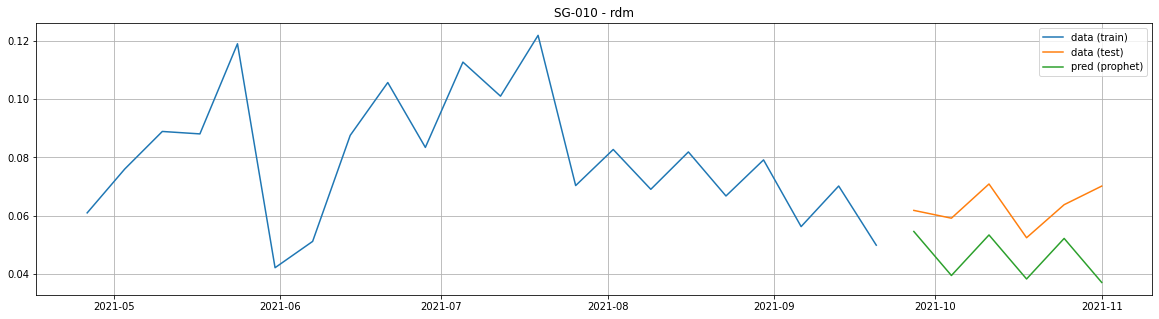

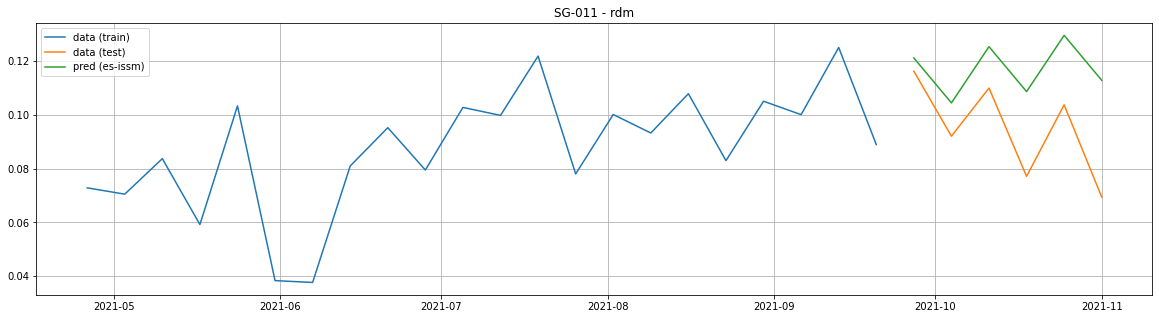

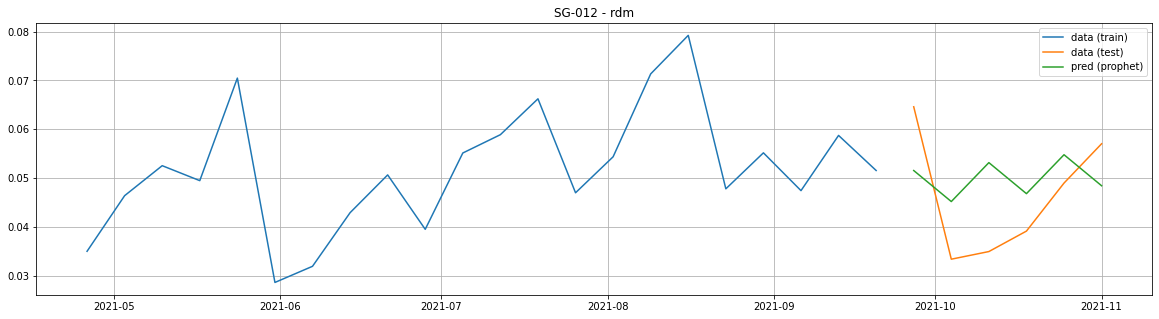

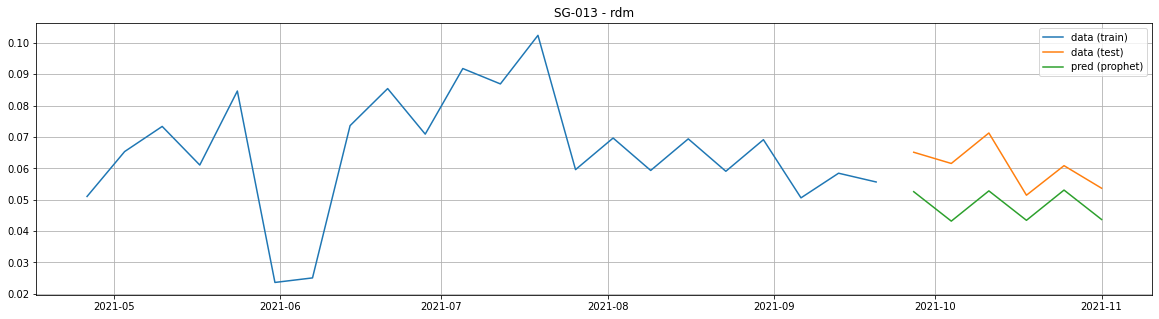

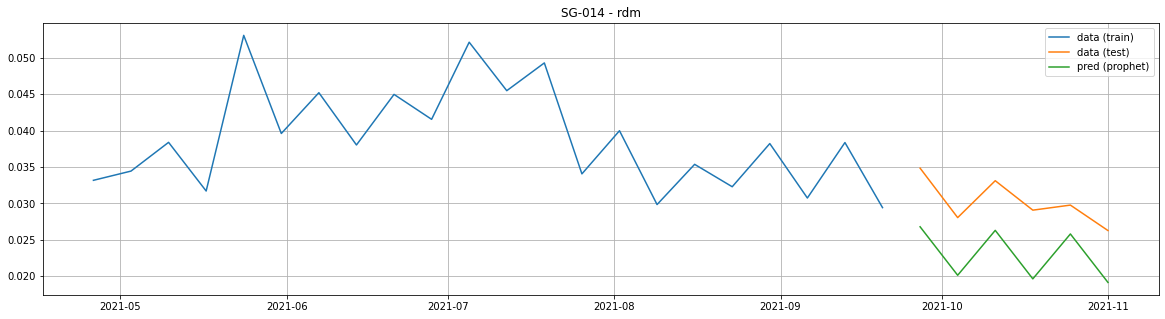

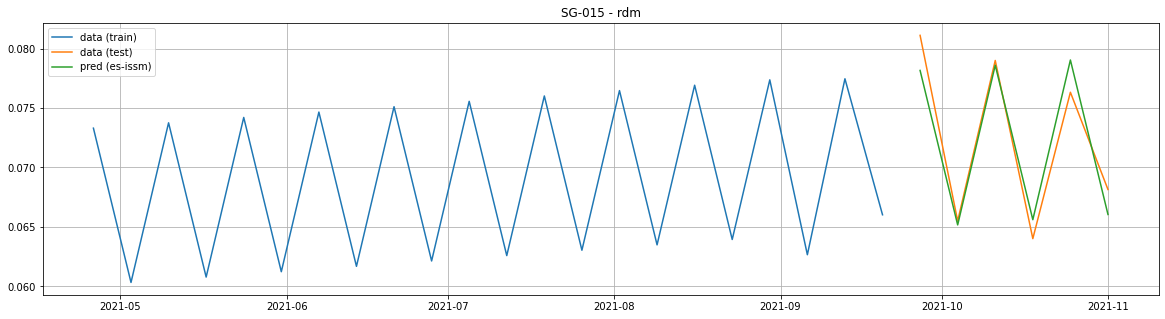

cost


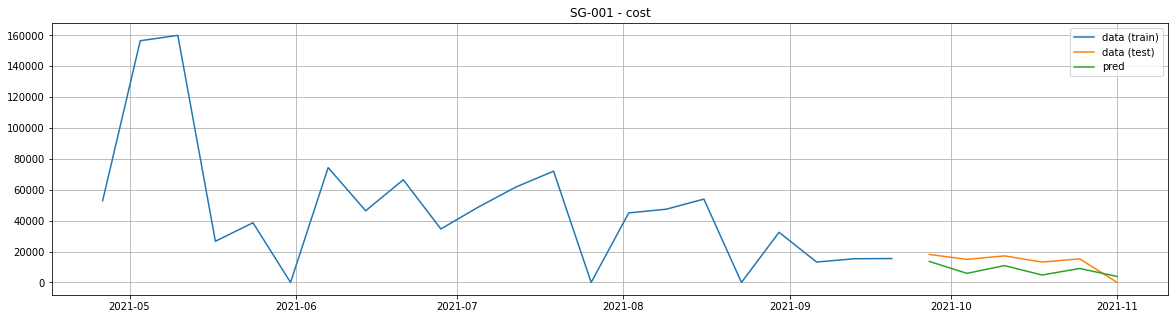

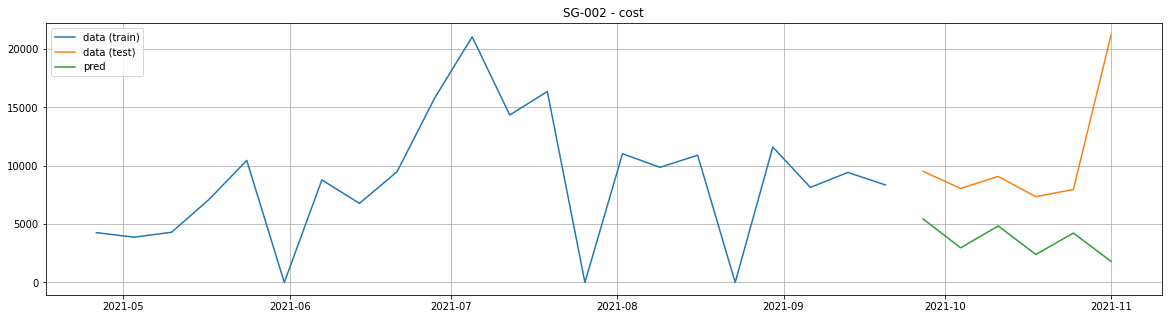

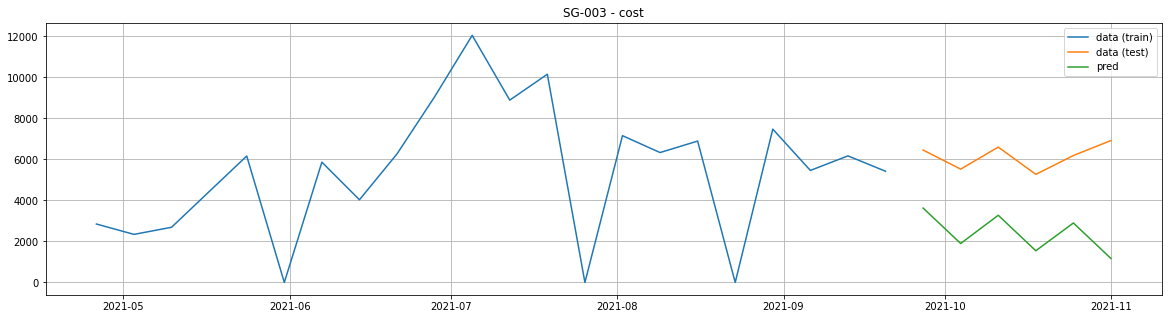

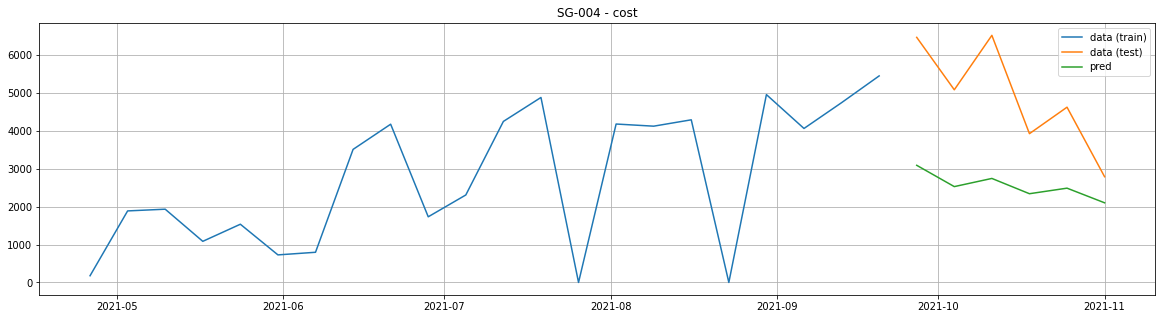

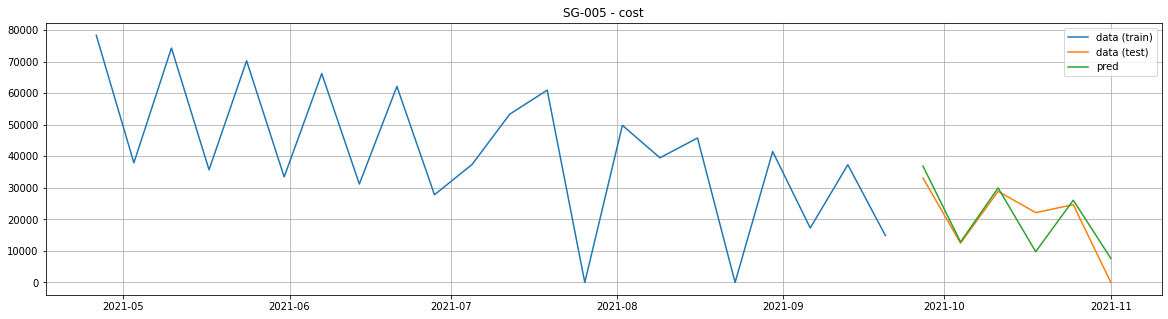

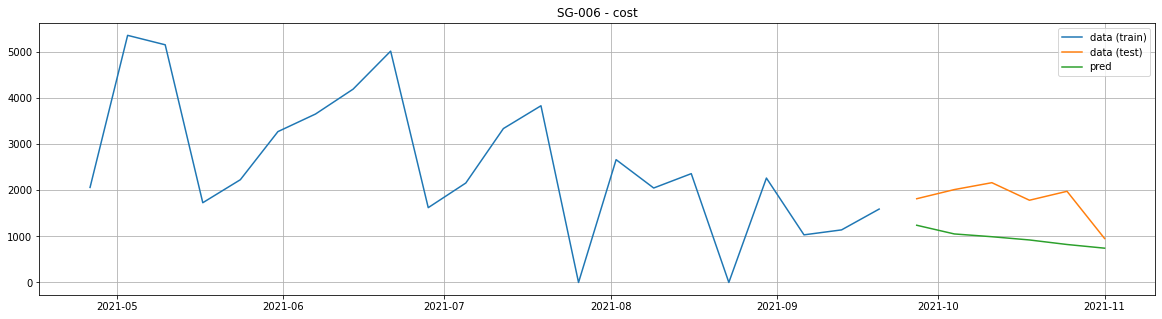

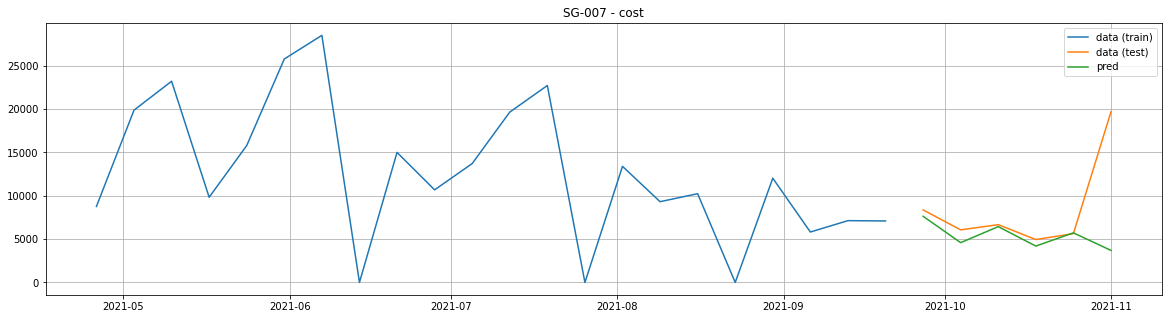

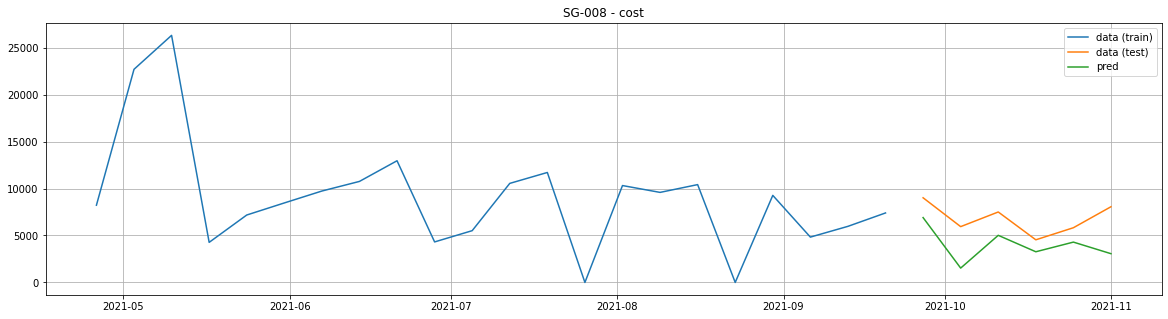

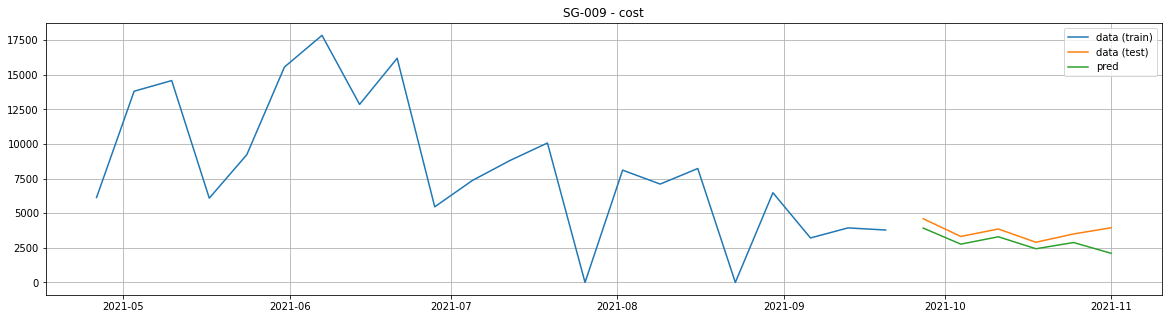

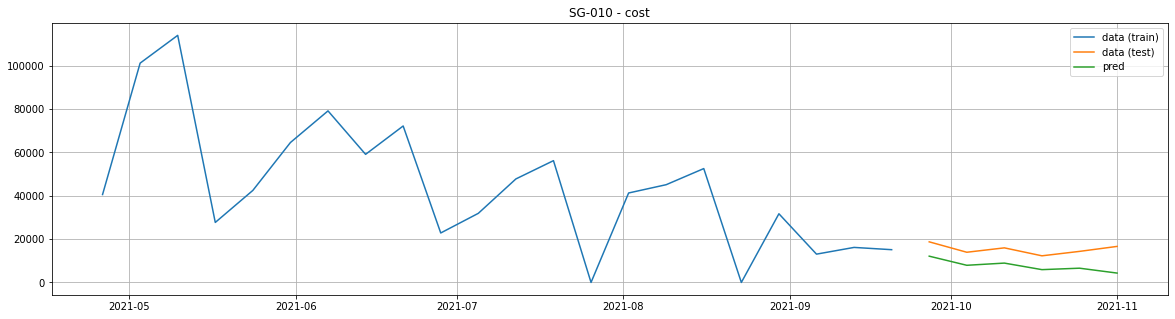

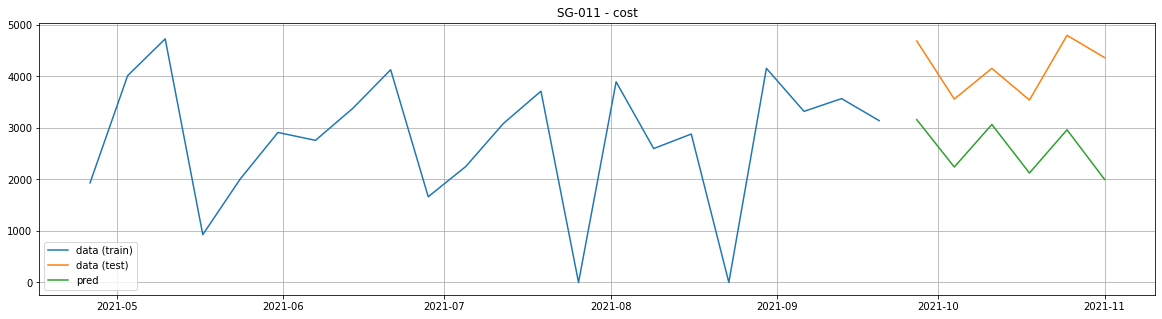

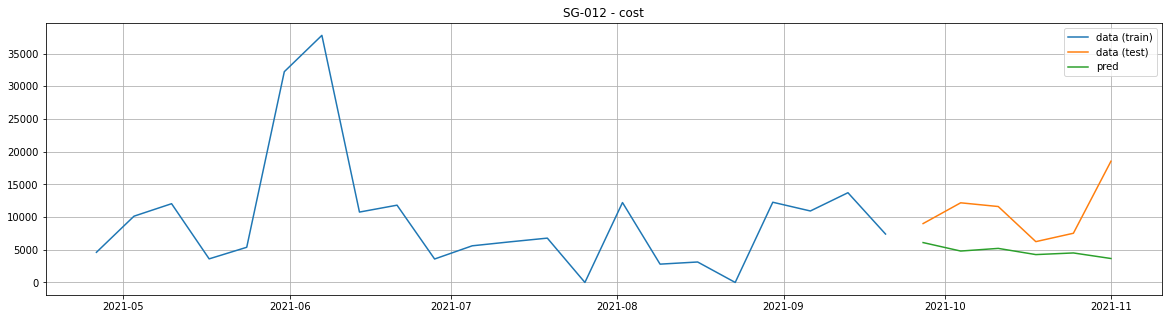

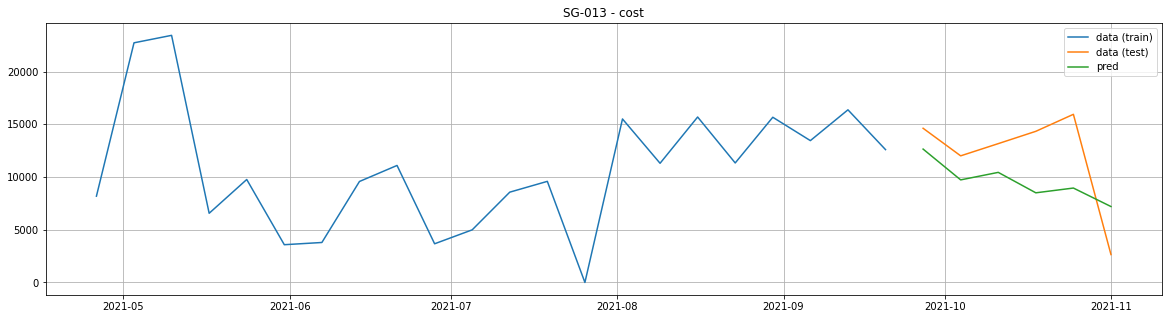

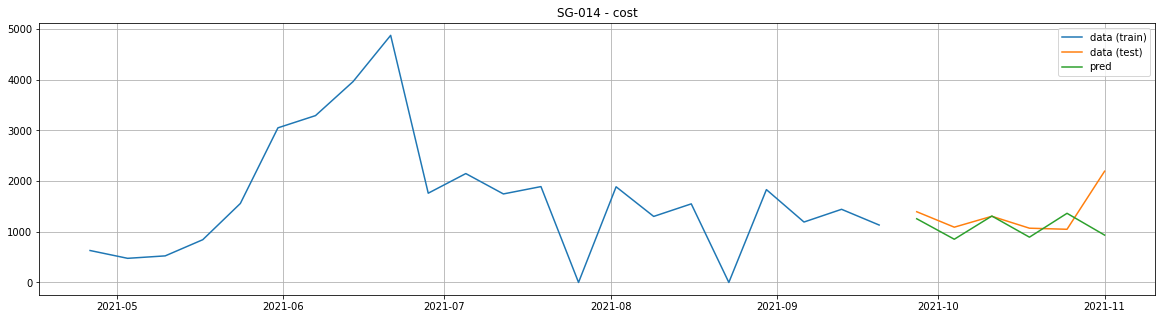

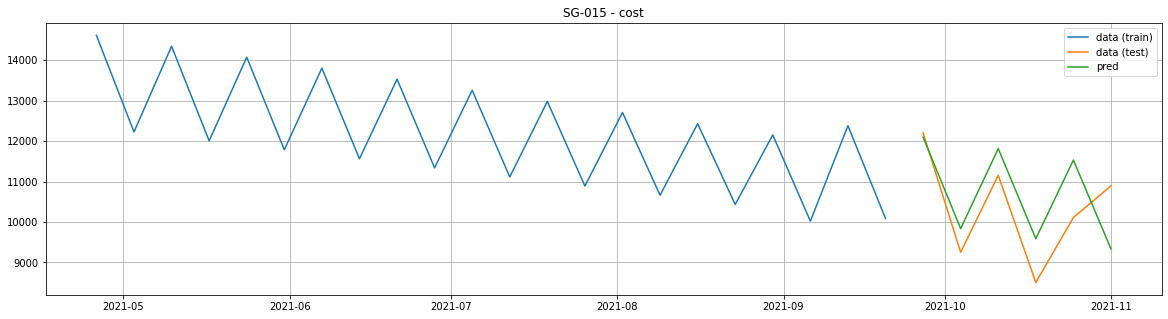

inc_sales


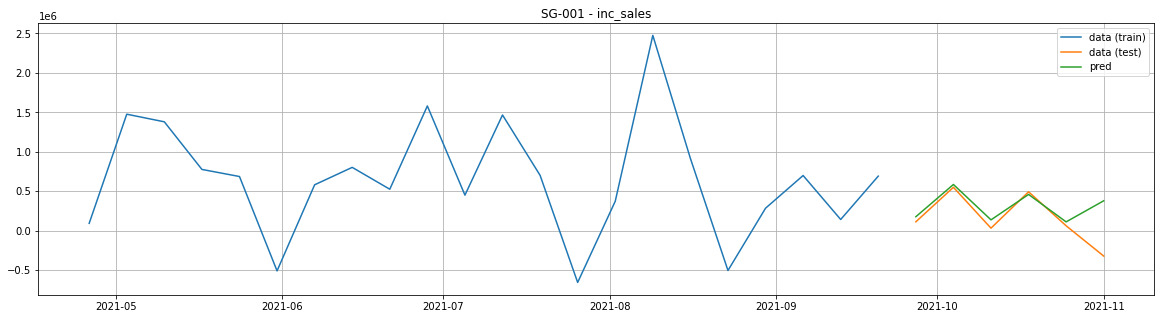

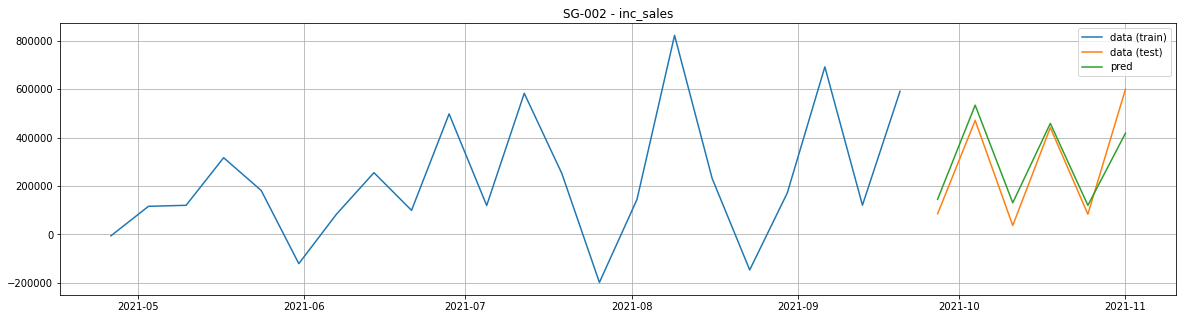

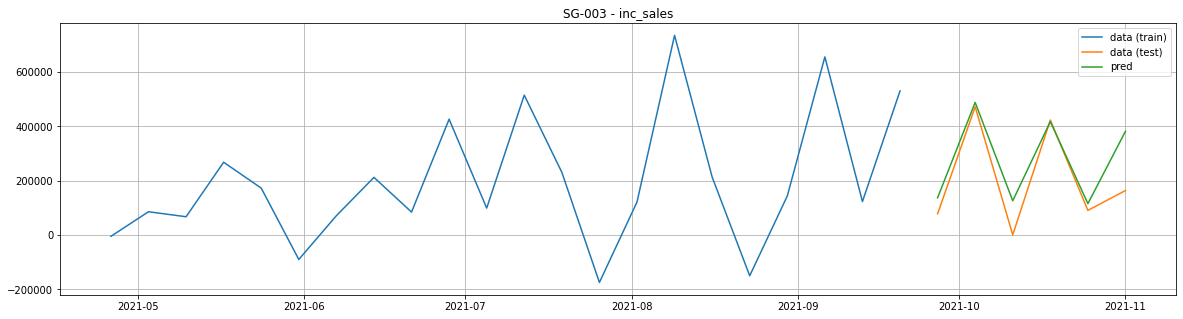

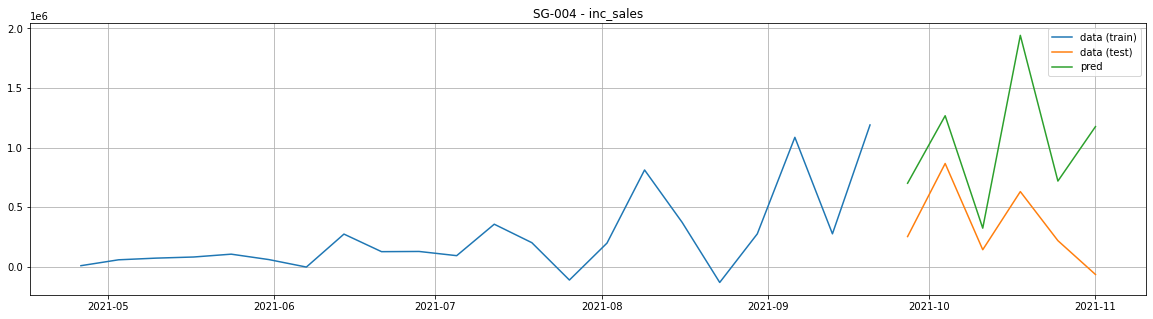

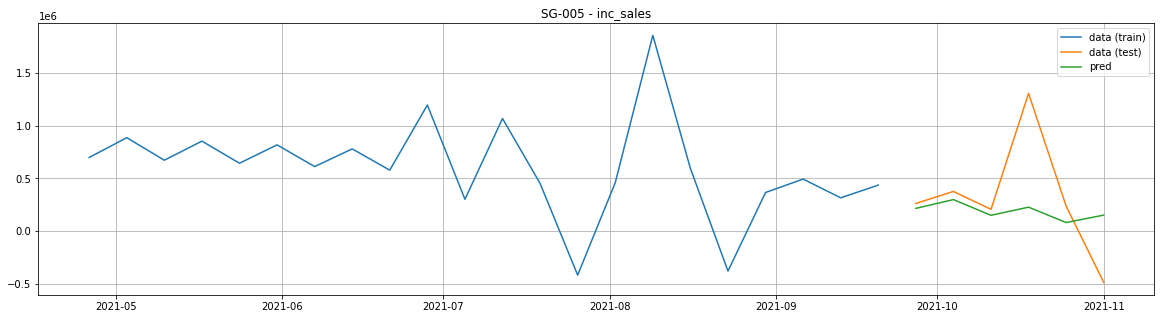

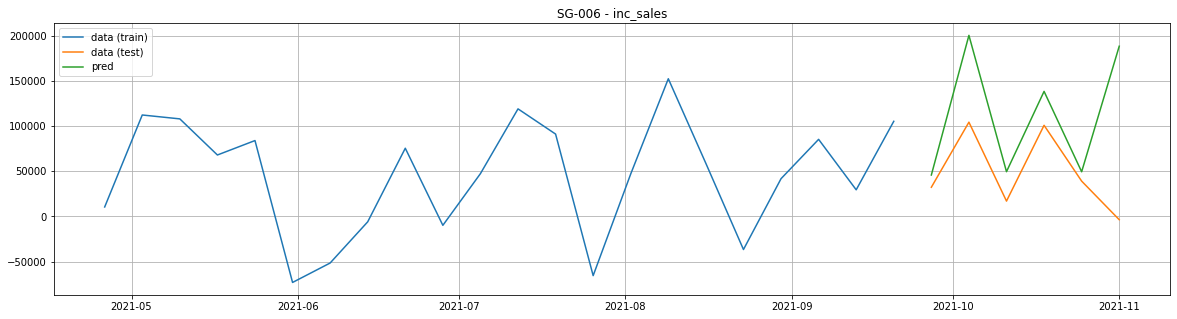

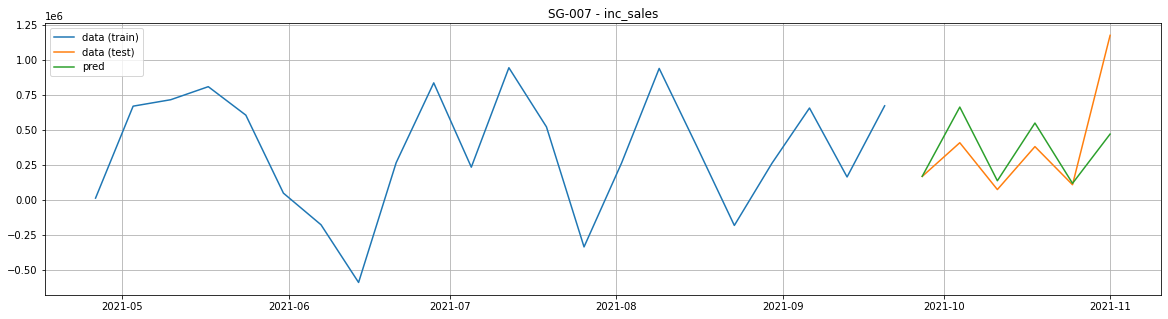

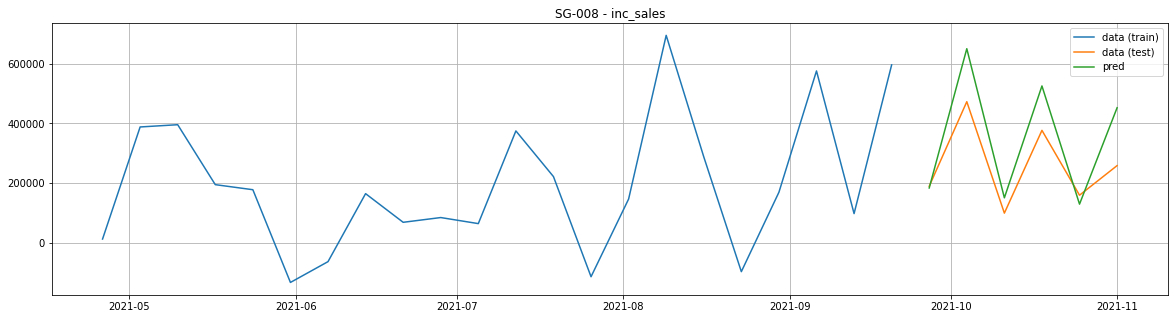

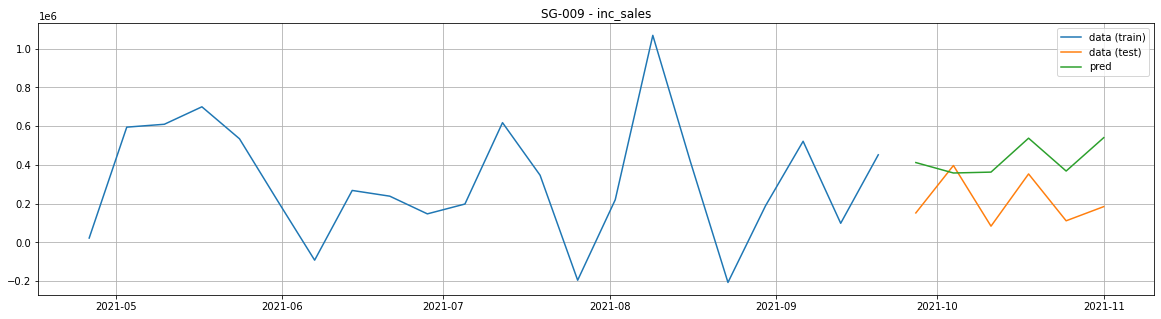

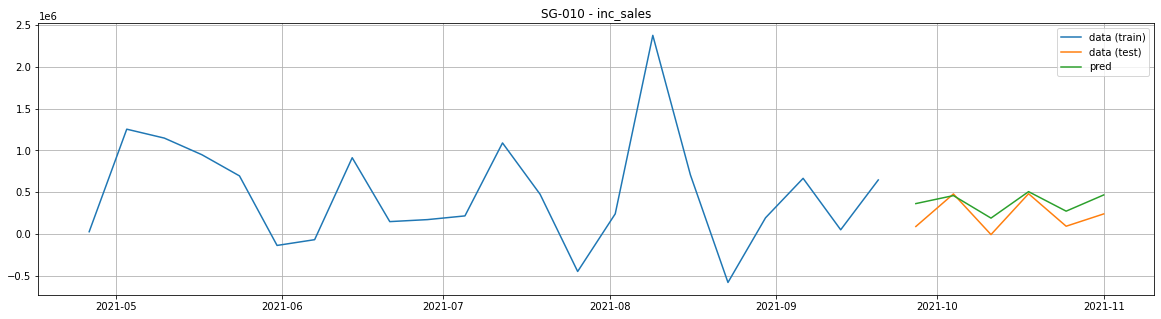

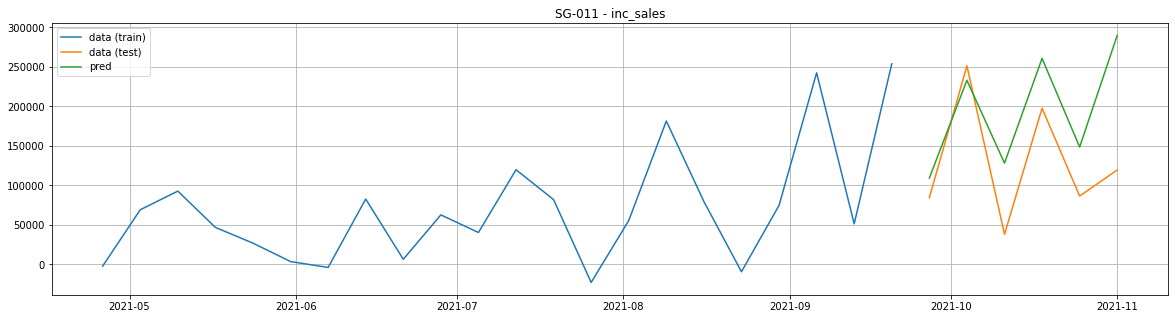

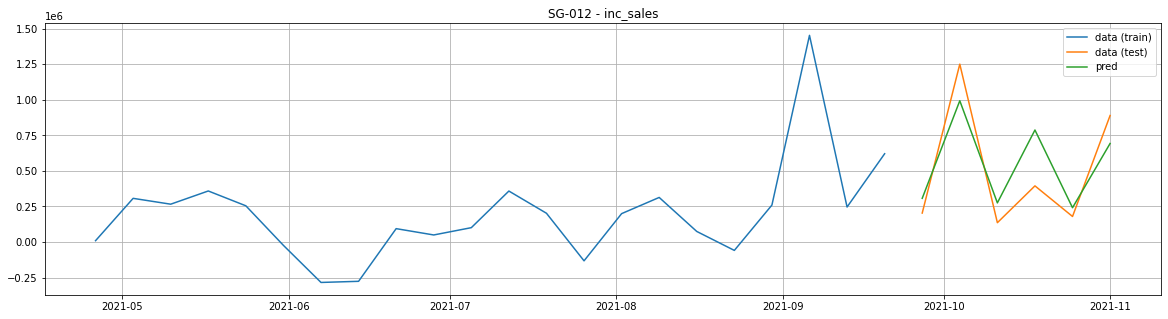

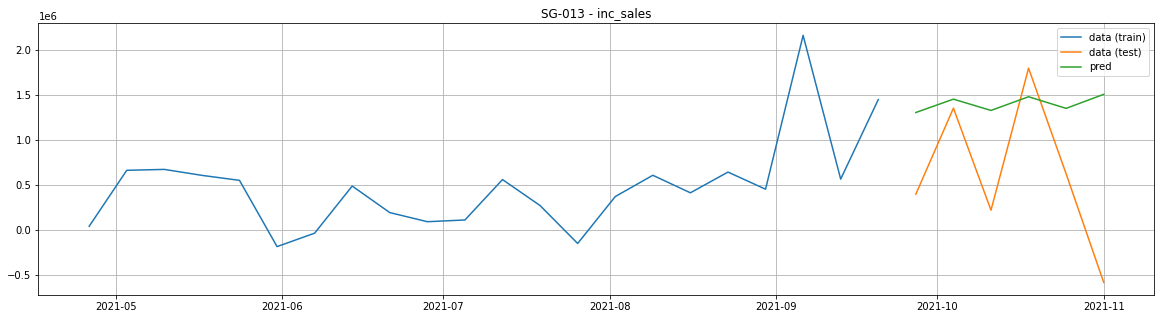

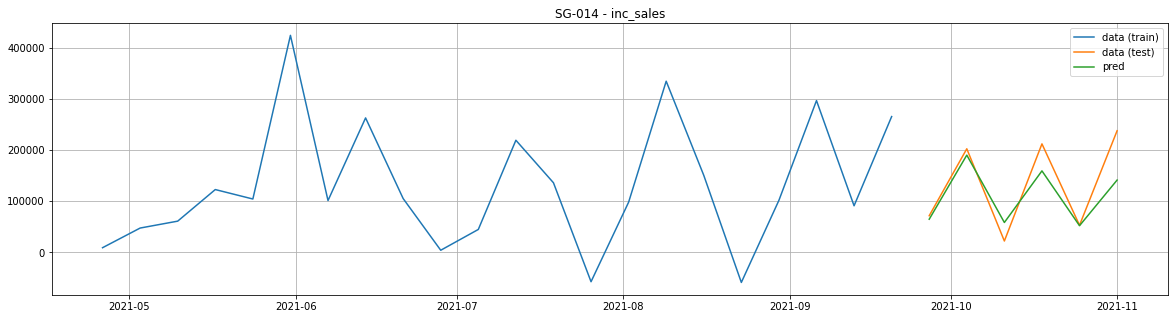

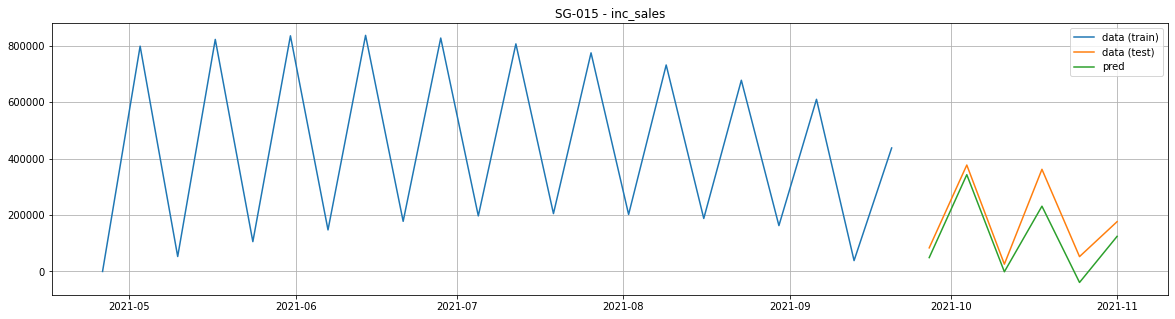

In [16]:
print("rpc")
single_plot("rpc")
    
print("rdm")
single_plot("rdm")

print("cost")
product_plot("cost")
    
print("inc_sales")
product_plot("inc_sales")

### Overall prediction

In [17]:
def predict_metric(metric):
    
    if metric == 'cost':
        scale, value = 'cpc', 'promo_audience'
    elif metric == 'redeemers':
        scale, value = 'rdm', 'promo_audience'
    elif metric == 'inc_sales':
        scale, value = 'rpc', 'promo_post_audience'
    
    yhat = 0
    for offer in offer_list:
        forecastClass = getattr(forecast, forecast_df.loc[offer, value])
#         forecastClass = getattr(forecast, 'ForecastNaive')
        myForecast = forecastClass(
            data=data, 
            offer_type=offer,
            metric=value,
            window=WINDOW
        )
        myForecast.train()
        pred_value = myForecast.predict()
        df_value = myForecast.df

        forecastClass = getattr(forecast, forecast_df.loc[offer, scale])
#         forecastClass = getattr(forecast, 'ForecastNaive')
        myForecast = forecastClass(
            data=data, 
            offer_type=offer,
            metric=scale,
            window=WINDOW
        )
        myForecast.train()
        pred_scale = myForecast.predict()

        yhat += pred_scale * pred_value
        
    return yhat


def predict_audience(scale):
    
    yhat = 0
    for offer in offer_list:
        forecastClass = getattr(forecast, forecast_df.loc[offer, scale])
#         forecastClass = getattr(forecast, 'ForecastNaive')
        myForecast = forecastClass(
            data=data, 
            offer_type=offer,
            metric=scale,
            window=WINDOW
        )
        myForecast.train()
        pred_scale = myForecast.predict()
        yhat += pred_scale 
        
    return yhat
        

In [18]:
%%time

result = {
    'cost': 0,
    'redeemers': 0,
    'inc_sales': 0,
    'promo_audience': 0,
    'promo_post_audience': 0
}

for metric in ['cost', 'redeemers', 'inc_sales']:
    result[metric] = predict_metric(metric)
    
for metric in ['promo_audience', 'promo_post_audience']:
    result[metric] = predict_audience(metric)

CPU times: user 4min 50s, sys: 1min 37s, total: 6min 27s
Wall time: 3min 46s


In [19]:
agg_data = data.groupby('ds').aggregate({'promo_post_audience':'sum', 'promo_audience':'sum', 'redeemers':'sum', 'inc_sales':'sum', 'cost':'sum'}).reset_index()
agg_data['rpc'] = agg_data['inc_sales'] / agg_data['promo_post_audience']
agg_data['rdm'] = agg_data['redeemers'] / agg_data['promo_audience']
agg_data['cpc'] = agg_data['cost'] / agg_data['promo_audience']

In [20]:
result_df = pd.DataFrame(result)
result_df.rename(columns={
    'cost': 'pred_cost',
    'redeemers': 'pred_redeemers',
    'inc_sales': 'pred_inc_sales',
    'promo_audience': 'pred_promo_audience',
    'promo_post_audience': 'pred_promo_post_audience'
}, inplace=True)

result_df['pred_rpc'] = result_df['pred_inc_sales'] / result_df['pred_promo_post_audience']
result_df['pred_rdm'] = result_df['pred_redeemers'] / result_df['pred_promo_audience']

result_df['ds'] = np.array(agg_data['ds'][-WINDOW:])

In [21]:
final_df = agg_data.merge(result_df, how='left', left_on='ds', right_on='ds')

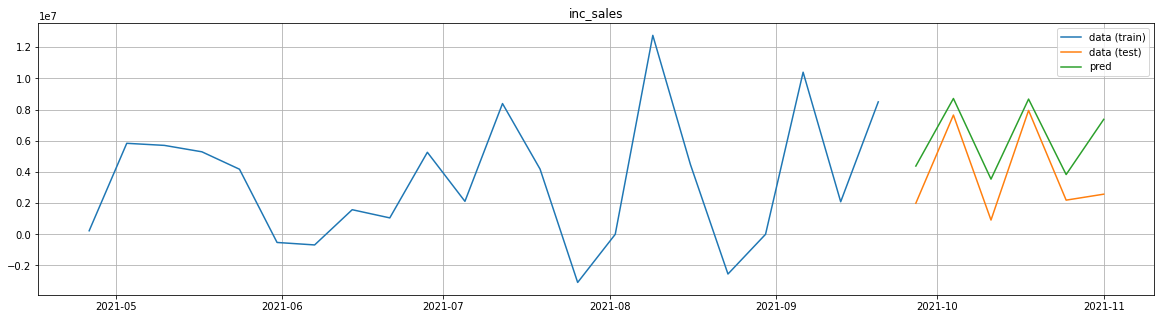

sMAPE = 30.443305321327564


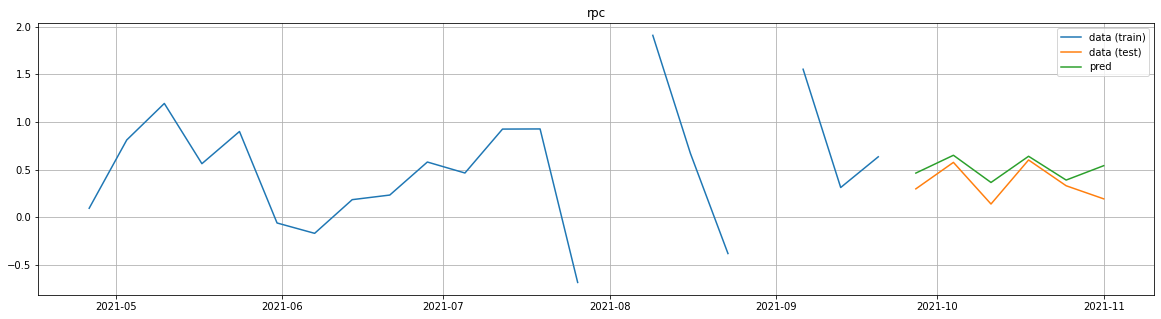

sMAPE = 21.926853669413013


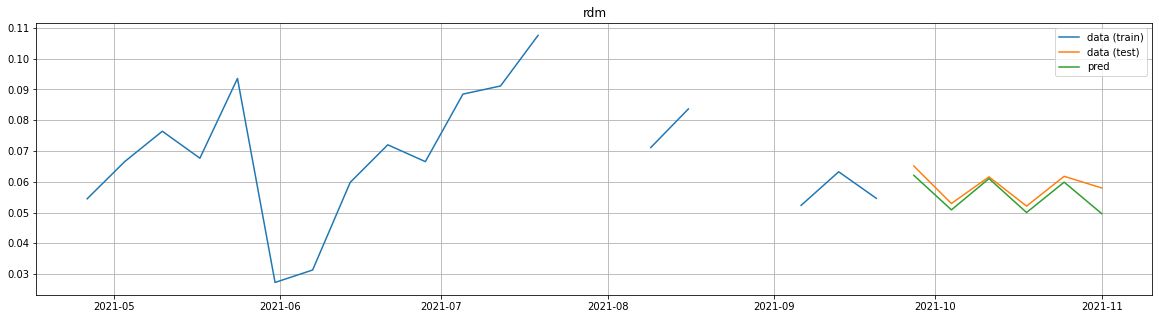

sMAPE = 2.702069072814594


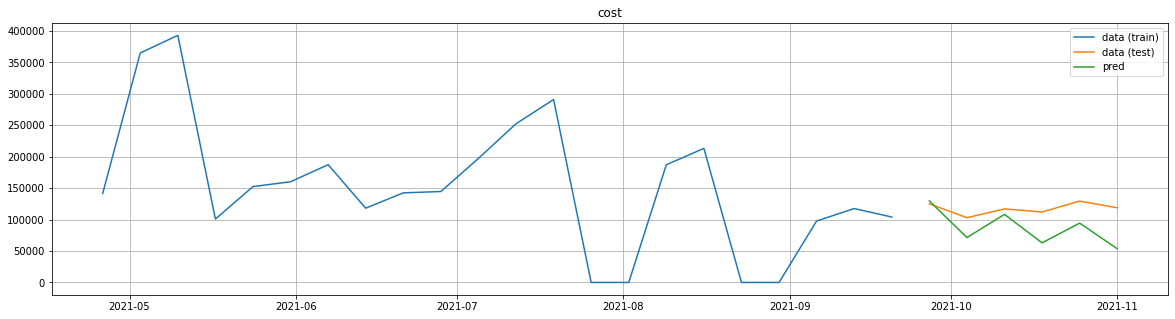

sMAPE = 17.554666913988367


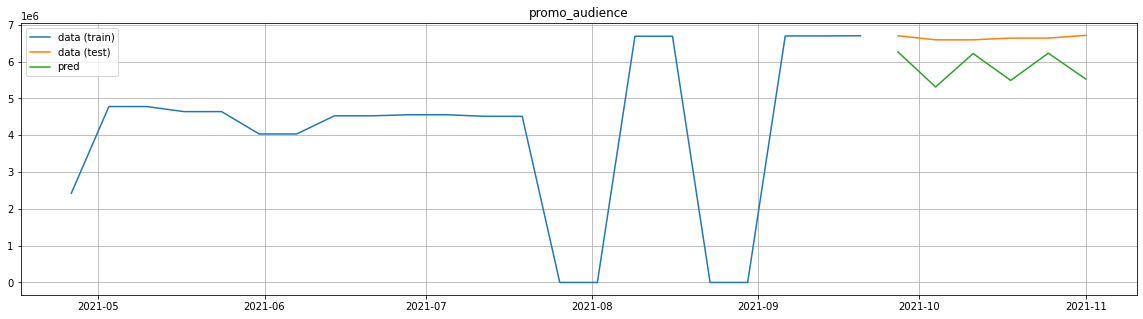

sMAPE = 6.569770620432319


In [40]:
def eval_smape(y, yhat):
    return np.mean(np.abs(yhat - y) / (np.abs(yhat) + np.abs(y))) * 100

metrics = ['inc_sales', 'rpc', 'rdm', 'cost', 'promo_audience']

for metric in metrics: 
    ds = final_df['ds']
    y = final_df[metric]
    yhat = final_df[f'pred_{metric}']

    plt.figure(figsize=(20,5))
    plt.title(metric)
    plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
    plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
    plt.plot(ds[-WINDOW:], yhat[-WINDOW:], label=f'pred')
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f'sMAPE = {eval_smape(y[-WINDOW:], yhat[-WINDOW:])}')

### Rolled up to Monthly

In [23]:
sql = '''
    SELECT * 
    FROM (
        SELECT DISTINCT 
            fp_start_date AS dt, 
            fw_start_date AS ds
        FROM `wx-bq-poc.loyalty.dim_date`
        WHERE fp_start_date >= '2020-08-31'
            AND DATE(fp_end_date) < current_date('Australia/ACT')
    )
'''

monthly = bq.query(sql).result().to_dataframe()

In [24]:
post_df = monthly.merge(final_df, left_on='ds', right_on='ds').sort_values(by='dt')
month_agg_data = post_df.groupby('dt').aggregate({
    'promo_post_audience': 'sum',
    'promo_audience': 'sum',
    'inc_sales': 'sum',
    'cost': 'sum',
    'redeemers': 'sum',
    'pred_promo_post_audience': 'sum',
    'pred_promo_audience': 'sum',
    'pred_inc_sales': 'sum',
    'pred_cost': 'sum',
    'pred_redeemers': 'sum',
}).reset_index()

month_agg_data['rpc'] = month_agg_data['inc_sales'] / month_agg_data['promo_post_audience']
month_agg_data['rdm'] = month_agg_data['redeemers'] / month_agg_data['promo_audience']

month_agg_data['pred_rpc'] = month_agg_data['pred_inc_sales'] / month_agg_data['pred_promo_post_audience']
month_agg_data['pred_rdm'] = month_agg_data['pred_redeemers'] / month_agg_data['pred_promo_audience']

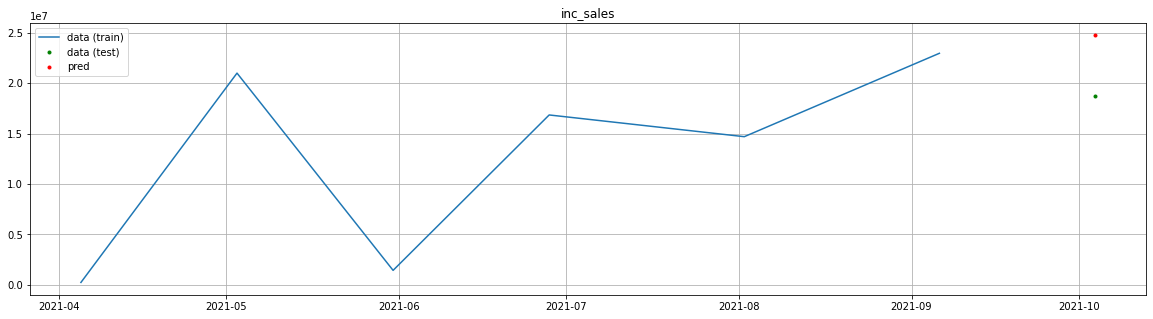

sMAPE = 13.928361144823759


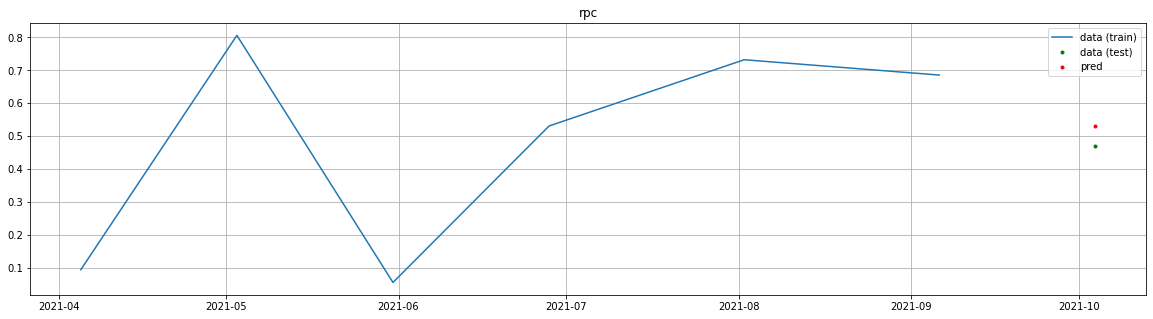

sMAPE = 6.174336439770598


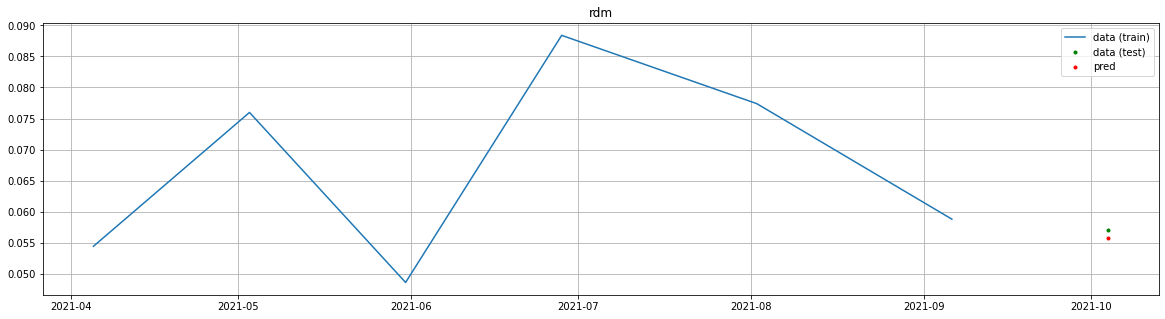

sMAPE = 1.1562865471474835


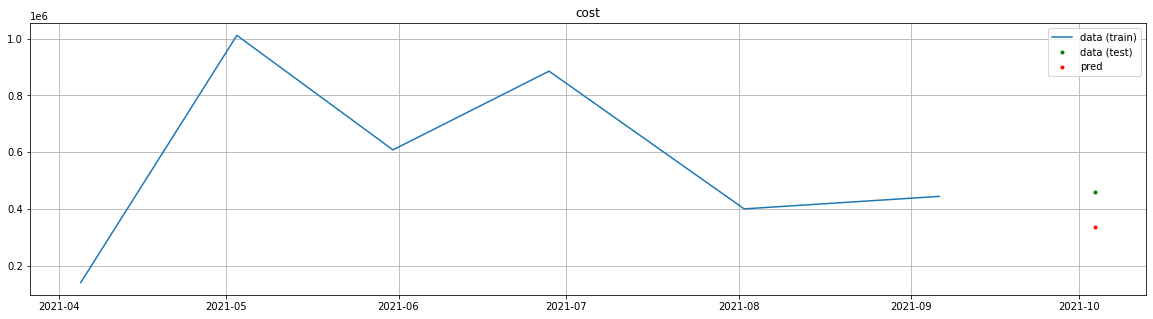

sMAPE = 15.587176712257428


In [25]:
metrics = ['inc_sales', 'rpc', 'rdm', 'cost']

for metric in metrics: 
    ds = month_agg_data['dt']
    y = month_agg_data[metric]
    yhat = month_agg_data[f'pred_{metric}']

    plt.figure(figsize=(20,5))
    plt.title(metric)
    plt.plot(ds[:-1], y[:-1], label='data (train)')
    plt.plot(ds[-1:], y[-1:], 'g.', label='data (test)')
    plt.plot(ds[-1:], yhat[-1:], 'r.', label=f'pred')
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f'sMAPE = {eval_smape(y[-1:], yhat[-1:])}')

### Comparison with marketing

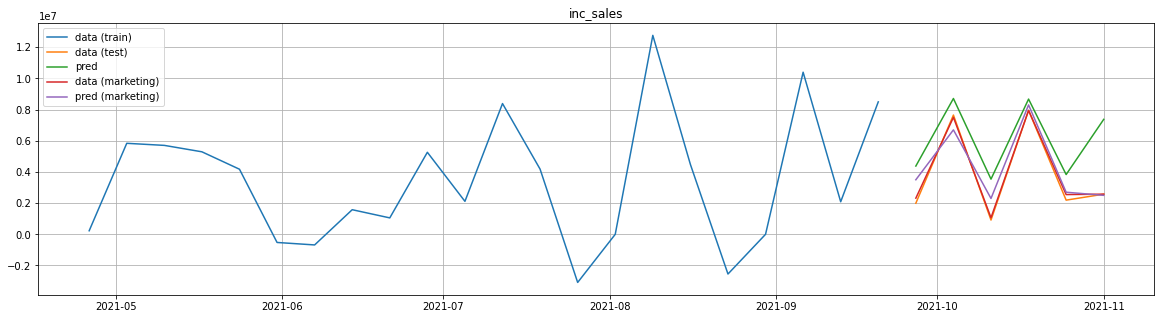

sMAPE (marketing) : 15.186249446704672
sMAPE (ours)      : 30.443305321327564


In [31]:
metric = 'inc_sales'
marketing = [2320016, 7501137, 1063701, 7947367, 2548977, 2575573]
marketing_forecast = [3500000.00, 6700000.00, 2300000.00, 8300000.00, 2700000.00, 2500000.00]

ds = final_df['ds']
y = final_df[metric]
yhat = final_df[f'pred_{metric}']

plt.figure(figsize=(20,5))
plt.title(metric)
plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
plt.plot(ds[-WINDOW:], yhat[-WINDOW:], label=f'pred')
plt.plot(ds[-WINDOW:], marketing, label=f'data (marketing)')
plt.plot(ds[-WINDOW:], marketing_forecast, label=f'pred (marketing)')
plt.legend()
plt.grid()
plt.show()

print(f'sMAPE (marketing) : {eval_smape(marketing_forecast, y[-WINDOW:])}')
print(f'sMAPE (ours)      : {eval_smape(yhat[-WINDOW:], y[-WINDOW:])}')

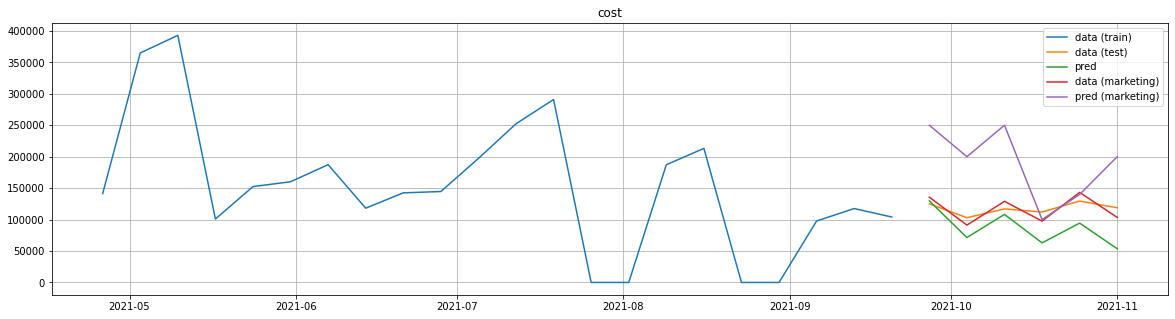

sMAPE (marketing) : 22.778736994826822
sMAPE (ours)      : 17.554666913988367


In [33]:
metric = 'cost'
marketing = [135577, 91206, 128973, 97576, 143228, 103417]
marketing_forecast = [250000, 200000, 250000, 100000, 140000, 200000]

ds = final_df['ds']
y = final_df[metric]
yhat = final_df[f'pred_{metric}']

plt.figure(figsize=(20,5))
plt.title(metric)
plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
plt.plot(ds[-WINDOW:], yhat[-WINDOW:], label=f'pred')
plt.plot(ds[-WINDOW:], marketing, label=f'data (marketing)')
plt.plot(ds[-WINDOW:], marketing_forecast, label=f'pred (marketing)')
plt.legend()
plt.grid()
plt.show()

print(f'sMAPE (marketing) : {eval_smape(marketing_forecast, y[-WINDOW:])}')
print(f'sMAPE (ours)      : {eval_smape(yhat[-WINDOW:], y[-WINDOW:])}')

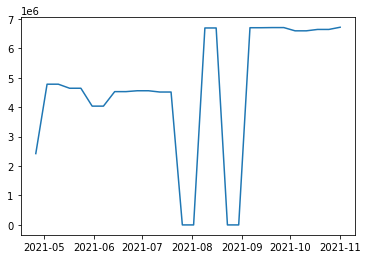

In [39]:
plt.plot(final_df['ds'], final_df['promo_audience'])